In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Dataset

In [2]:
df = pd.read_csv('data_banjir_filtered.csv')

print("Dataset Original:")
print(f"Shape: {df.shape}")
print(f"\nTarget Distribution:")
print(df['banjir'].value_counts())
print(f"\nClass Balance: {df['banjir'].value_counts(normalize=True) * 100}")

Dataset Original:
Shape: (10980, 16)

Target Distribution:
banjir
0    10135
1      845
Name: count, dtype: int64

Class Balance: banjir
0    92.304189
1     7.695811
Name: proportion, dtype: float64


## 2. Encode Target Variable

In [3]:
df['banjir'] = df['banjir'].map({0: 0, 1: 1, 'Ya': 1, 'Tidak': 0})

print("Target variable encoded:")
print(df['banjir'].value_counts())

Target variable encoded:
banjir
0    10135
1      845
Name: count, dtype: int64


## 3. Handle Outliers

Menggunakan IQR method untuk mendeteksi dan handle outliers

In [5]:
numerical_features = ['avg_rainfall', 'max_rainfall', 'avg_temperature', 
                      'elevation', 'ndvi', 'slope', 'soil_moisture', 'jumlah_penduduk']

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

print("Outlier Detection:")
print("=" * 70)

outlier_counts = {}
for col in numerical_features:
    lower, upper = detect_outliers_iqr(df, col)
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = len(outliers)
    print(f"{col:25s}: {len(outliers):6d} outliers ({len(outliers)/len(df)*100:5.2f}%)")

total_rows_with_outliers = 0
for idx in df.index:
    has_outlier = False
    for col in numerical_features:
        lower, upper = detect_outliers_iqr(df, col)
        if df.loc[idx, col] < lower or df.loc[idx, col] > upper:
            has_outlier = True
            break
    if has_outlier:
        total_rows_with_outliers += 1

print(f"\nTotal rows with any outlier: {total_rows_with_outliers}")

Outlier Detection:
avg_rainfall             :    257 outliers ( 2.34%)
max_rainfall             :    330 outliers ( 3.01%)
avg_temperature          :     19 outliers ( 0.17%)
elevation                :   1680 outliers (15.30%)
ndvi                     :      0 outliers ( 0.00%)
slope                    :   1920 outliers (17.49%)
soil_moisture            :    665 outliers ( 6.06%)
jumlah_penduduk          :    420 outliers ( 3.83%)

Total rows with any outlier: 3019

Total rows with any outlier: 3019


In [6]:
df_no_outliers = df.copy()

for col in numerical_features:
    lower, upper = detect_outliers_iqr(df_no_outliers, col)
    df_no_outliers[col] = df_no_outliers[col].clip(lower=lower, upper=upper)

print("Outliers handled using clipping method")
print(f"Shape before: {df.shape}")
print(f"Shape after: {df_no_outliers.shape}")

Outliers handled using clipping method
Shape before: (10980, 16)
Shape after: (10980, 16)


## 4. Feature Engineering

Membuat fitur baru berdasarkan domain knowledge

In [7]:
df_engineered = df_no_outliers.copy()

df_engineered['rainfall_intensity'] = df_engineered['max_rainfall'] / (df_engineered['avg_rainfall'] + 1)

df_engineered['is_rainy_season'] = df_engineered['month'].apply(
    lambda x: 1 if x in [11, 12, 1, 2, 3] else 0
)

df_engineered['elevation_slope_ratio'] = df_engineered['elevation'] / (df_engineered['slope'] + 1)

df_engineered['vegetation_moisture'] = df_engineered['ndvi'] * df_engineered['soil_moisture']

df_engineered['population_density_proxy'] = df_engineered['jumlah_penduduk'] / (df_engineered['elevation'] + 1)

df_engineered['extreme_rainfall'] = (df_engineered['max_rainfall'] > df_engineered['max_rainfall'].quantile(0.75)).astype(int)

print("New features created:")
print("  - rainfall_intensity")
print("  - is_rainy_season")
print("  - elevation_slope_ratio")
print("  - vegetation_moisture")
print("  - population_density_proxy")
print("  - extreme_rainfall")

print(f"\nTotal features: {df_engineered.shape[1]}")

New features created:
  - rainfall_intensity
  - is_rainy_season
  - elevation_slope_ratio
  - vegetation_moisture
  - population_density_proxy
  - extreme_rainfall

Total features: 22


## 5. Encode Categorical Variables

In [8]:
df_encoded = df_engineered.copy()

le_landcover = LabelEncoder()
df_encoded['landcover_encoded'] = le_landcover.fit_transform(df_encoded['landcover_class'])

print("Landcover encoding:")
for i, label in enumerate(le_landcover.classes_):
    print(f"  {i}: {label}")

landcover_dummies = pd.get_dummies(df_encoded['landcover_class'], prefix='landcover')
df_encoded = pd.concat([df_encoded, landcover_dummies], axis=1)

print(f"\nOne-hot encoded landcover features: {landcover_dummies.shape[1]}")

Landcover encoding:
  0: Built-up
  1: Cropland
  2: Permanent water bodies
  3: Tree cover

One-hot encoded landcover features: 4

One-hot encoded landcover features: 4


## 6. Feature Scaling

Standardisasi fitur numerik untuk model ML

In [9]:
df_scaled = df_encoded.copy()

features_to_scale = numerical_features + [
    'rainfall_intensity', 'elevation_slope_ratio', 
    'vegetation_moisture', 'population_density_proxy'
]

scaler = StandardScaler()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

print("Features scaled using StandardScaler")
print(f"\nScaled features ({len(features_to_scale)}):")
for feat in features_to_scale:
    print(f"  - {feat}")

print(f"\nScaled data statistics:")
print(df_scaled[features_to_scale].describe().T[['mean', 'std', 'min', 'max']])

Features scaled using StandardScaler

Scaled features (12):
  - avg_rainfall
  - max_rainfall
  - avg_temperature
  - elevation
  - ndvi
  - slope
  - soil_moisture
  - jumlah_penduduk
  - rainfall_intensity
  - elevation_slope_ratio
  - vegetation_moisture
  - population_density_proxy

Scaled data statistics:
                                  mean       std       min       max
avg_rainfall              1.397789e-16  1.000046 -1.610042  2.751770
max_rainfall              5.176996e-17  1.000046 -1.806227  2.604902
avg_temperature          -1.035399e-17  1.000046 -3.042624  2.315370
elevation                -1.527214e-16  1.000046 -0.854325  1.992664
ndvi                     -1.048342e-16  1.000046 -2.108491  2.638275
slope                     8.412619e-18  1.000046 -1.009254  1.874305
soil_moisture             7.299565e-16  1.000046 -2.229227  1.898063
jumlah_penduduk           1.326605e-16  1.000046 -1.730604  2.577786
rainfall_intensity        2.277878e-16  1.000046 -2.671006  4.78909

## 7. Final Dataset Summary

In [10]:
print("=" * 70)
print("FINAL DATASET SUMMARY")
print("=" * 70)

print(f"\nShape: {df_scaled.shape}")
print(f"Original shape: {df.shape}")
print(f"Features added: {df_scaled.shape[1] - df.shape[1]}")

print(f"\nMissing values: {df_scaled.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(df_scaled.select_dtypes(include=[np.number])).sum().sum()}")

print(f"\nTarget distribution:")
print(df_scaled['banjir'].value_counts())
print(f"\nClass balance: {df_scaled['banjir'].value_counts(normalize=True) * 100}")

print(f"\nColumn types:")
print(df_scaled.dtypes.value_counts())

FINAL DATASET SUMMARY

Shape: (10980, 27)
Original shape: (10980, 16)
Features added: 11

Missing values: 0
Infinite values: 0

Target distribution:
banjir
0    10135
1      845
Name: count, dtype: int64

Class balance: banjir
0    92.304189
1     7.695811
Name: proportion, dtype: float64

Column types:
float64    14
int64       4
bool        4
object      3
int32       2
Name: count, dtype: int64


## 8. Save Processed Datasets

In [11]:
df_scaled.to_csv('data_banjir_processed.csv', index=False)
print("Processed dataset saved: data_banjir_processed.csv")

df_engineered.to_csv('data_banjir_engineered.csv', index=False)
print("Engineered dataset (unscaled) saved: data_banjir_engineered.csv")

import os
size_original = os.path.getsize('data_banjir_filtered.csv') / 1024 / 1024
size_processed = os.path.getsize('data_banjir_processed.csv') / 1024 / 1024

print(f"\nFile sizes:")
print(f"  Original: {size_original:.2f} MB")
print(f"  Processed: {size_processed:.2f} MB")

Processed dataset saved: data_banjir_processed.csv
Engineered dataset (unscaled) saved: data_banjir_engineered.csv

File sizes:
  Original: 1.16 MB
  Processed: 3.38 MB
Engineered dataset (unscaled) saved: data_banjir_engineered.csv

File sizes:
  Original: 1.16 MB
  Processed: 3.38 MB


## 9. Visualization - Before vs After

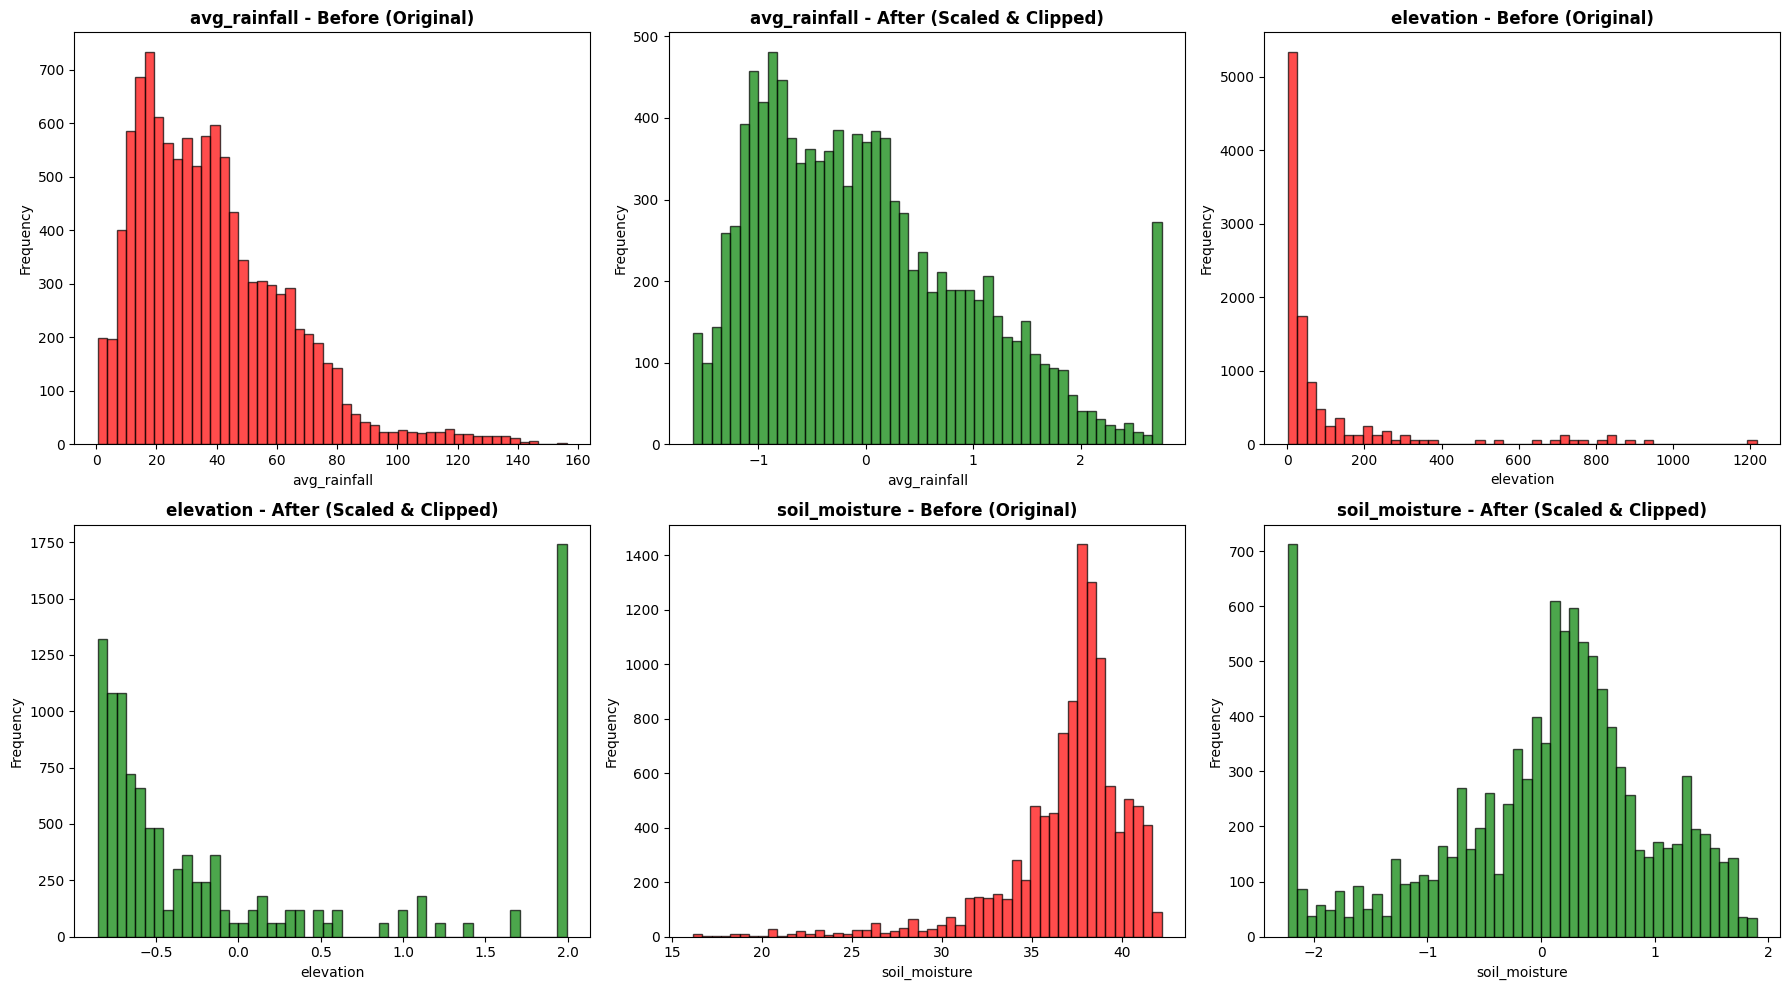

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

sample_features = ['avg_rainfall', 'elevation', 'soil_moisture']

for idx, feat in enumerate(sample_features):
    axes[idx*2].hist(df[feat], bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[idx*2].set_title(f'{feat} - Before (Original)', fontweight='bold')
    axes[idx*2].set_xlabel(feat)
    axes[idx*2].set_ylabel('Frequency')
    
    axes[idx*2+1].hist(df_scaled[feat], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[idx*2+1].set_title(f'{feat} - After (Scaled & Clipped)', fontweight='bold')
    axes[idx*2+1].set_xlabel(feat)
    axes[idx*2+1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 10. Correlation Analysis - New Features

Correlation of new features with target:
extreme_rainfall              :  0.1710
is_rainy_season               :  0.1143
elevation_slope_ratio         :  0.0163
population_density_proxy      :  0.0009
rainfall_intensity            : -0.0636
vegetation_moisture           : -0.0786


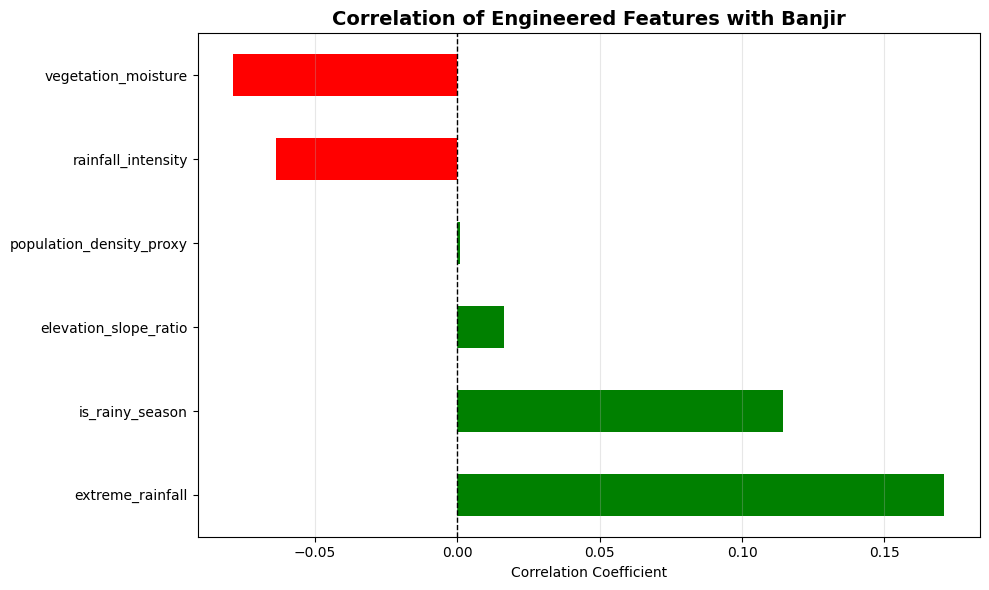

In [13]:
new_features = ['rainfall_intensity', 'is_rainy_season', 'elevation_slope_ratio', 
                'vegetation_moisture', 'population_density_proxy', 'extreme_rainfall']

correlation_with_target = df_engineered[new_features + ['banjir']].corr()['banjir'].drop('banjir').sort_values(ascending=False)

print("Correlation of new features with target:")
print("=" * 50)
for feat, corr in correlation_with_target.items():
    print(f"{feat:30s}: {corr:7.4f}")

plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlation_with_target])
plt.title('Correlation of Engineered Features with Banjir', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Feature Importance Preview

Top 10 features by absolute correlation with target:
 1. avg_rainfall                  :  0.1904
 2. max_rainfall                  :  0.1729
 3. extreme_rainfall              :  0.1710
 4. soil_moisture                 :  0.1578
 5. jumlah_penduduk               :  0.1313
 6. is_rainy_season               :  0.1143
 7. ndvi                          :  0.1031
 8. vegetation_moisture           :  0.0786
 9. rainfall_intensity            :  0.0636
10. avg_temperature               :  0.0249


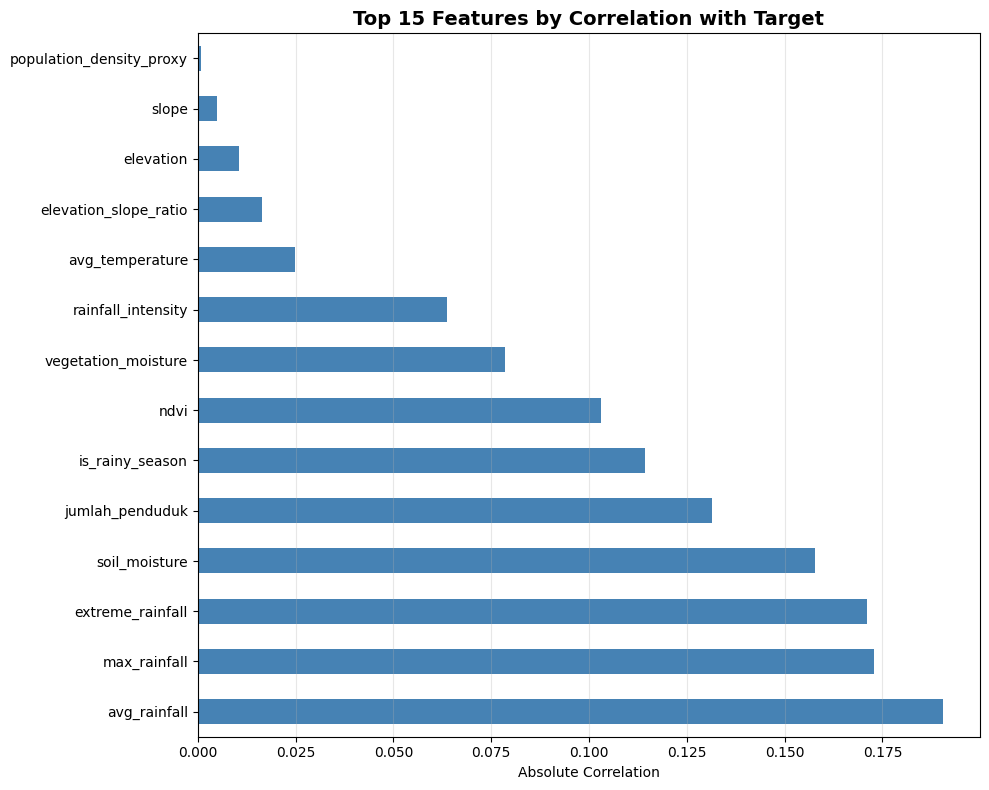

In [14]:
all_numerical = numerical_features + new_features
feature_target_corr = df_engineered[all_numerical + ['banjir']].corr()['banjir'].drop('banjir').abs().sort_values(ascending=False)

print("Top 10 features by absolute correlation with target:")
print("=" * 60)
for i, (feat, corr) in enumerate(feature_target_corr.head(10).items(), 1):
    print(f"{i:2d}. {feat:30s}: {corr:7.4f}")

plt.figure(figsize=(10, 8))
feature_target_corr.head(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 Features by Correlation with Target', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
print("=" * 70)
print("DATASET PROCESSING COMPLETED")
print("=" * 70)
print("\nProcessing steps applied:")
print("  1. Outlier handling (IQR clipping)")
print("  2. Feature engineering (6 new features)")
print("  3. Categorical encoding (label + one-hot)")
print("  4. Feature scaling (StandardScaler)")
print("\nOutput files:")
print("  - data_banjir_processed.csv (scaled, ready for ML)")
print("  - data_banjir_engineered.csv (unscaled, with new features)")
print("\nNext steps:")
print("  - Use data_banjir_processed.csv for model training")
print("  - Apply train-test split with stratification")
print("  - Consider SMOTE if class imbalance persists")

DATASET PROCESSING COMPLETED

Processing steps applied:
  1. Outlier handling (IQR clipping)
  2. Feature engineering (6 new features)
  3. Categorical encoding (label + one-hot)
  4. Feature scaling (StandardScaler)

Output files:
  - data_banjir_processed.csv (scaled, ready for ML)
  - data_banjir_engineered.csv (unscaled, with new features)

Next steps:
  - Use data_banjir_processed.csv for model training
  - Apply train-test split with stratification
  - Consider SMOTE if class imbalance persists
